https://github.com/devnag/pytorch-generative-adversarial-networks/blob/master/gan_pytorch.py  
https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9  


In [1]:
# Generative Adversarial Networks (GAN) example in PyTorch.
# See related blog post at https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
#https://pytorch.org/docs/master/autograd.html

In [2]:
# Data params
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)
num_epochs = 30000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [3]:
# ### Uncomment only one of these
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

print("Using data [%s]" % (name))

Using data [Data and variances]


In [4]:
# ##### DATA: Target data and generator input data

def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian


In [5]:
# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)


In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

In [7]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

In [8]:
d_sampler = get_distribution_sampler(data_mean, data_stddev)
print ("type(d_sampler):", type(d_sampler))
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

type(d_sampler): <class 'function'>


In [20]:
stored = []
stored_a = []
stored_b = []
stored1_real = []
stored1_fake = []

for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        #temp = d_sampler(d_input_size)
        #print ("type(temp):", type(temp))
        d_real_data = Variable(d_sampler(d_input_size))
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
        
        
    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters

    if epoch % print_interval == 0:
        temp = (epoch,
                extract(d_real_error)[0],
                extract(d_fake_error)[0],
                extract(g_error)[0],
                stats(extract(d_real_data)),
                stats(extract(d_fake_data)))
        stored.append(temp)
        stored_a.append(temp[4][0])
        stored_b.append(temp[5][0])
        stored1_real.append(temp[1])
        stored1_fake.append(temp[1])
        print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % temp)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0: D: 0.26924601197242737/0.5790197849273682 G: 0.6961740851402283 (Real: [3.932873830795288, 1.4001971728479963], Fake: [3.3655900436639787, 1.2459060258491081]) 
200: D: 0.03467188775539398/0.30427953600883484 G: 1.6814968585968018 (Real: [3.7982712621241808, 1.4125549195711913], Fake: [4.568638919591904, 1.4993564254254923]) 
400: D: 0.7243065237998962/0.8014926910400391 G: 0.6928409934043884 (Real: [4.1340279340744015, 1.2322868052846712], Fake: [4.23100579380989, 1.3120249769174201]) 
600: D: 0.6856873035430908/0.9089756608009338 G: 1.2756330966949463 (Real: [3.9974478375911713, 1.2233236127084697], Fake: [3.7460406821966172, 1.1321688990051373]) 
800: D: 0.6323590874671936/0.7285125851631165 G: 0.5339120626449585 (Real: [3.875502069592476, 1.2069154855262298], Fake: [3.8985476696491244, 1.168995487228072]) 
1000: D: 0.01244212593883276/0.42324817180633545 G: 1.1765708923339844 (Real: [4.023740546703339, 1.1746598248021758], Fake: [5.120981595516205, 1.4386961845098625]) 
1200: D:

10000: D: 0.6314613819122314/0.7372571229934692 G: 0.6270459890365601 (Real: [4.074633872509002, 1.221895977426022], Fake: [3.8824450635910033, 1.1997863909291098]) 
10200: D: 0.6330438256263733/0.589076578617096 G: 0.8657198548316956 (Real: [3.929322375357151, 1.2585528760351115], Fake: [4.730200459957123, 1.3828922951894502]) 
10400: D: 0.9556484222412109/0.4974775016307831 G: 0.8838102221488953 (Real: [4.235516096353531, 1.2826455714847949], Fake: [4.638159601688385, 1.5634172317297221]) 
10600: D: 1.000725507736206/0.7902283072471619 G: 0.6801953911781311 (Real: [4.178810482025146, 1.4487626949645345], Fake: [3.11022301197052, 1.0220621955027607]) 
10800: D: 0.6511038541793823/0.5815680623054504 G: 0.8704527020454407 (Real: [4.015704871863127, 1.2584644874202229], Fake: [4.722391073703766, 1.1297551290395063]) 
11000: D: 0.6993310451507568/0.6197646856307983 G: 1.3052549362182617 (Real: [3.980049101114273, 1.1335346082923567], Fake: [3.499208354949951, 1.2743617264483624]) 
11200: 

20000: D: 0.7439497709274292/0.5180284976959229 G: 0.7516778707504272 (Real: [3.870075897872448, 1.1773426882968425], Fake: [4.3559413695335385, 1.1947470746646112]) 
20200: D: 0.6239239573478699/0.8024529814720154 G: 0.6134110689163208 (Real: [4.058379180431366, 1.207651788348804], Fake: [3.4226163911819456, 1.0840519613058364]) 
20400: D: 0.9000486731529236/0.48295921087265015 G: 0.7885292768478394 (Real: [3.9958160424232485, 1.2523195147976993], Fake: [4.3009798717498775, 1.197009378976843]) 
20600: D: 0.4010743796825409/0.3840467929840088 G: 0.9197696447372437 (Real: [4.00797678232193, 1.2513989928785287], Fake: [4.096762516498566, 1.490366549222586]) 
20800: D: 0.8029771447181702/0.7087218761444092 G: 0.9508050680160522 (Real: [3.7498234928399325, 1.1752366321455103], Fake: [3.923311500549316, 1.135499769623144]) 
21000: D: 0.5313102006912231/0.746877908706665 G: 0.653181254863739 (Real: [3.888906844854355, 1.1277799474813484], Fake: [3.611567018032074, 1.1652762324444994]) 
21200

In [21]:
len(stored)

150

In [22]:
stored[0]

(0,
 0.26924601197242737,
 0.5790197849273682,
 0.6961740851402283,
 [3.932873830795288, 1.4001971728479963],
 [3.3655900436639787, 1.2459060258491081])

In [23]:
stored[0][4][0]

3.932873830795288

In [24]:
stored[0][5][0]

3.3655900436639787

In [25]:
stored_a[0], len(stored_a)

(3.932873830795288, 150)

In [26]:
stored_b[0], len(stored_b)

(3.3655900436639787, 150)

In [27]:
x = list(range(len(stored_a)))

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

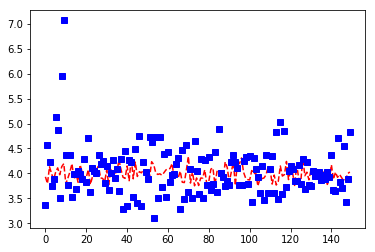

In [29]:
plt.plot(x, stored_a, 'r--', x, stored_b, 'bs')
plt.show()


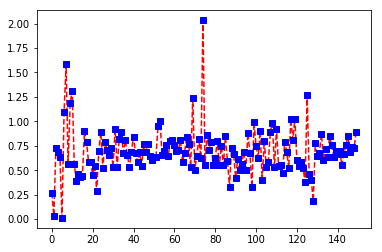

In [30]:
plt.plot(x, stored1_real, 'r--', x, stored1_fake, 'bs')
plt.show()
